---
# Practical 1. Recap of the standard neutral coalescent and an intro to coalescence simulations with msprime
---

At the end of this practical you should:

- Understand what a coalescent simulation is and what the relevant data structures are.
- Know how to run and analyse coalescent simulations with [`msprime`](https://tskit.dev/msprime/docs/stable/intro.html) and [`tskit`](https://tskit.dev/tskit/docs/stable/python-api.html#trees-and-tree-sequences).
- Understand the extent to which the variance of the coalescent depends on the two major axis of sampling: # of loci, # of individuals ([Felsenstein 2004](https://academic.oup.com/mbe/article-lookup/doi/10.1093/molbev/msj079)).
- Understand why it is natural (and helpful) to treat mutations separately from ancestry.

## 1.1 Getting started

### Importing python tools

<div class="alert alert-block alert-warning">
    <b>Python recipe:</b> We will generally import python tools in the fisrt code cell of a jupyter practical notebook. 
    
There are several tools we will use throughout the course: <code>msprime</code> is a powerful and well documented coalescent simulator. In fact, this notebook is based largely on the "Running Simulations" section in the <code>msprime</code> <a href="https://tskit.dev/msprime/docs/stable/mutations.html">manual</a>.

<a href="https://numpy.org/"><code>numpy</code></a> is an open source python library that is widely used for scientific computing.  If you are new to `python` or need a refresher about basic <code>python</code> concepts, have a look at practical_0.
<a href="https://matplotlib.org/"><code>matplotlib</code></a>
</div>

In [9]:
import msprime
import tskit
from IPython.display import SVG, set_matplotlib_formats
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from collections import Counter

## 1.2 Build your own simulator

Population genetic models are algorithmic by nature, i.e. forwards in time they specify how a population evolves from one generation to the next, backwards in time models are framed in terms of the probabilities of the next event in the ancestry of a sample. It is unsurprising that a large number of population genetic simulators (both forward and backwards) exist. Simulating under the standard standard neutral coalescent, the simplest backwards in time model, is straightforward in principle.

In fact, if we're only interested in coalescence times, a coalescent simulation is just a set of random draws of coalescence times from an exponential distribuition. We can do this with the `random` method in `numpy`. Let's draw 1_000 pairwise coalescence times for a population with an effective size of $N_e= 10000$:

In [2]:
num_replicates = 1_000
pair_times_array = np.random.exponential(20_000, num_replicates);

Note that the result which we have assigned to a variable `pair_times_array` is a numpy array of floats:

In [7]:
type(pair_times_array)

numpy.ndarray

We can use python indexing to examine the first 10 simulation replicates:

In [8]:
pair_times_array[0:10]

array([32063.08816306, 12597.73078615, 28882.47395057,  1300.27537443,
       15746.04695159,  3867.62491105, 44149.87901881,  4364.2320834 ,
       13323.27790475,  7685.245547  ])

<div class="alert alert-block alert-warning">
    <b>Python recipe:</b> We can use the <a href="https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot/"><code>displot()</code></a> plot method to plot the distribution of pairwise coalescence times:
</div>

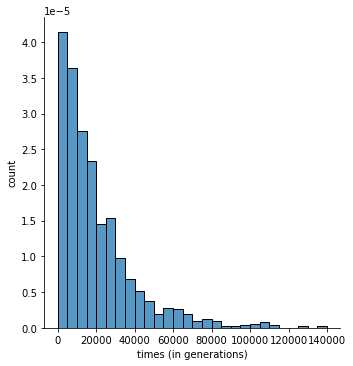

In [13]:
p = sns.displot(x = pair_times_array, stat = "density", label = 'span of trees', binwidth = 5_000)
plt.xlabel("times (in generations)");
plt.ylabel("count");

<div class="alert alert-block alert-success">    
    <b>Exercise 1:</b> Find the <a href="https://numpy.org/doc/stable/"><code>numpy<code></a> methods for computing the mean and standard deviation of an array and check how well the mean of the 1_000 pairwise coalescence times simulated above matches the analytic expectation.
</div>

In [14]:
#SOL
print("The mean pairwise coalescence time is", pair_times_array.mean())
print("The standard deviation of pariwise coalescence times is", pair_times_array.std())

The mean pairwise coalescence time is 19855.24218588832
The standard deviation of pariwise coalescence times is 19917.294363833746


<div class="alert alert-block alert-info">
    <b>PopGen:</b> A basic property of the coalescent is that the rate is proportional to the number of pairs of lineages, and so changes after each coalescent event. When there are  $i$ lineages the rate of coalescence is $\lambda = \binom i 2 = \frac{i (i-1)}{2}$.
    </div>

<div class="alert alert-block alert-warning">
    <b>Python recipe:</b> Writing your own function is easy! The code chunck below defines a coalescence time simulator as a function. <code>coaltimes</code> has three arguments: <code>samplesize</code>,  <code>Ne</code> and  <code>replicates</code>, i.e. for a sample of size $n$ and a given $N_e$, <code>coaltimes</code> uses <a href="https://numpy.org/doc/stable/reference/random/generated/numpy.random.exponential.html"><code>np.random.exponential()</code></a> to draw $n-1$ random coalescence times:
    </div>

In [21]:
def coaltimes(samplesize, Ne, replicates):
    list_of_coal_intervals = [np.random.exponential(2* Ne/int(i*(i-1)/2), replicates) for i in range(2,samplesize+1)]
    return np.asarray(list_of_coal_intervals)

<div class="alert alert-block alert-success">    
    <b>Exercise 2:</b> What <code>numpy</code> functions and methods does <code>coaltimes</code> use? The waiting time for most other possible processes that affect the ancestry of a sample (e.g. mutation, migration, recombination events) depend on the number of lineages that are present (rather than the number of possible pairs). Copy <code>coaltimes</code> in the cell below and modify it to define a new function that draws waiting times at a rate proportional to the number of lineages (rather than the number of pairs).
    
<b>Hint:</b> Read the docs of <a href="https://numpy.org/doc/stable/reference/random/generated/numpy.random.exponential.html"><code>np.random.exponential()</code></a> to understand what input paramneters this function takes.
    </div>

In [22]:
#SOL
#random.exponential
#range()
#int()
def generaltimes(samplesize, rate, replicates):
    list_of_coal_intervals = [np.random.exponential(rate/i, replicates) for i in range(2,samplesize+1)]
    return np.asarray(list_of_coal_intervals)

<div class="alert alert-block alert-success">    
    <b>Exercise 3:</b>  Use <code>coaltimes</code> to simulate 1_000 replicate sets of coalescence times for a sample of $n=9$ (don't forget to assign the output to a new, helpful variable name)

In [23]:
#SOL
n9_times_array = coaltimes(9, 10_000, num_replicates)

<div class="alert alert-block alert-success">    
    <b>Exercise 4:</b> Use the funtion <code>type()</code> and the method <code>shape</code> to check what form the output of <code>coaltimes </code> takes.

In [24]:
#SOL
print(type(n9_times_array))
n9_times_array.shape

<class 'numpy.ndarray'>


(8, 1000)

<div class="alert alert-block alert-success">    
    <b>Exercise 5:</b> Compute the $T_{MRCA}$ of each simulation replicate (as the sum of internode intervals) and use <code>sns.displot()</code> to visualize the distribution of $T_{MRCA}$ arcoss replicates.
       </div>

In [25]:
##SOL
tmrca=sum(n9_times_array)

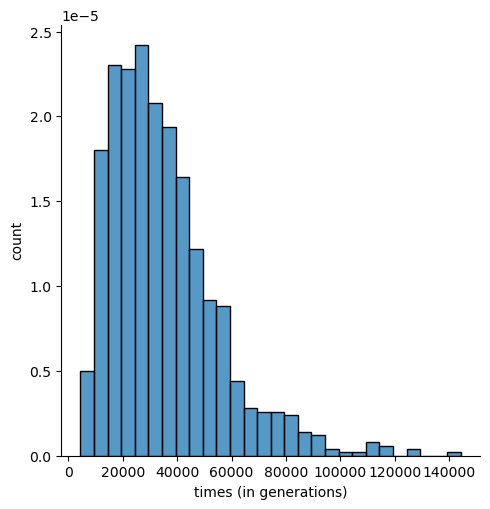

In [11]:
##SOL
sns.displot(x = tmrca, stat = "density", label = 'span of trees', binwidth = 5_000)
plt.xlabel("times (in generations)");
plt.ylabel("count")
plt.show()

<div class="alert alert-block alert-success">    
    <b>Exercise 6:</b> What is the mean $T_{MRCA}$ arcoss replicates?

In [26]:
#SOL
print("The mean Tmrca is", tmrca.mean())

The mean Tmrca is 34463.93973245694


<div class="alert alert-block alert-success">    
    <b>Exercise 7:</b> How well does this match the expectation?

<div class="alert alert-block alert-info">
    <b>PopGen hint:</b>
work out the expected times between coalescent intervals first and use the fact that $E[T_{MRCA}] = \sum_{i=2}^{n-1} E[T_i]$

In [9]:
#SOL
expected_intervals = [2/(i *(i-1)) for i in range(2,10)];
print(expected_intervals)

[1.0, 0.3333333333333333, 0.16666666666666666, 0.1, 0.06666666666666667, 0.047619047619047616, 0.03571428571428571, 0.027777777777777776]


In [10]:
#SOL
print("The mean Tmrca is" sum(expected_intervals)* 20000)plt.hist(,bins=30)
plt.xlabel("times (in generations)");
plt.ylabel("count")
plt.show()


35555.555555555555

<div class="alert alert-block alert-success">    
    <b>Exercise 8:</b> What is missing from this simulation?

In [80]:
#SOL
#Topologies! A more realistic model of the population.

## 1.3 A simple `msprime` ancestry simulation

We can set up a single simulation using `sim_ancestry()` which is a method of `msprime`. The `samples` argument of `sim_ancestry` defines the sampled individuals whose history will be simulated. In the simplest case, we provide a single integer which defines the number of samples.

<div class="alert alert-block alert-warning">
    <b>Python recipe:</b> Typing the variable assigned to this <code>msprime</code> simulation generates a useful, tabular summary of the simulation output.

In [3]:
simple_ts = msprime.sim_ancestry(9);
simple_ts

<div class="alert alert-block alert-warning">
    <b>Python recipe:</b> Strictly speaking <code>sim_ancestry()</code> always returns a treesequence (more on these practical 3). However, in this case we have only simulated a single tree. We can use the method <code>.first()</code> to extract this tree:

In [4]:
simple_tree = simple_ts.first()

<div class="alert alert-block alert-warning">
    <b>Python recipe:</b> We can plot our simulated tree using the method <code>.draw_svg()</code>:

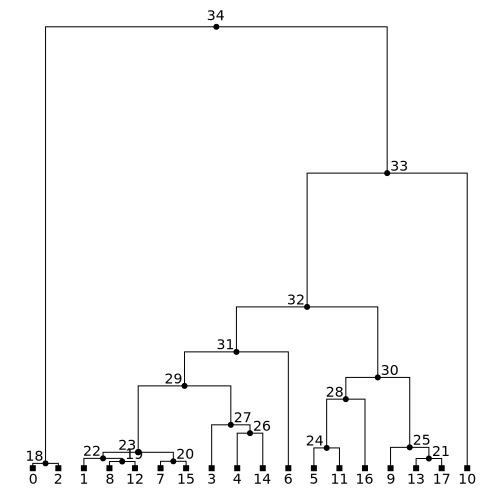

In [5]:
SVG(simple_tree.draw_svg(size=(500, 500)))

<div class="alert alert-block alert-success">    
    <b>Exercise 9:</b>  Why does the tree we simulated contain 18 sample nodes and 35 nodes in total? How would you change the arguments of <code>sim_ancestry</code> to match the simulation we have assumed for our DIY coalescence time simulator above?

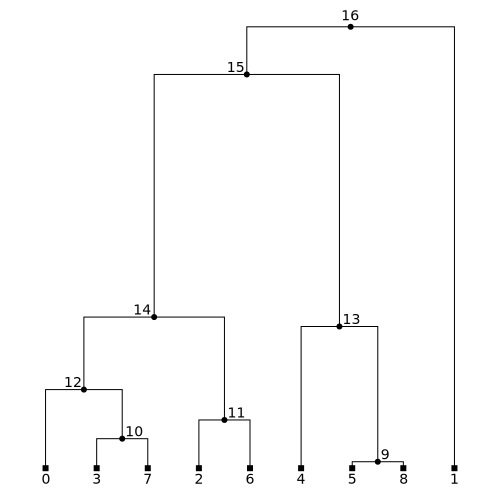

In [6]:
#SOL: define ploidy = 1. The point is to realize that msprime and pop gen models in general assume diploidy.
simple_ts = msprime.sim_ancestry(9, ploidy=1);
simple_tree = simple_ts.first()
SVG(simple_tree.draw_svg(size=(500, 500)))

<div class="alert alert-block alert-success">    
    <b>Exercise 10:</b> Use the <a href="https://tskit.dev/tskit/docs/stable/python-api.html#the-tree-class"><code>.root</code></a> attribute to find the rootnode of this tree and the <code>time()</code> method to find the $T_{MRCA}$.**

In [7]:
#SOL
root = simple_tree.root
#Having defined the root, we can use the `time` method to find the time of the root node, aka the $T_{mrca}$:
print("The tmrca is", simple_tree.time(root))

The tmrca is 1.088082006976019


We can use a `for` loop to loop over all nodes in the tree to find the associated coalescence times. Note the use of the `.nodes()` method in the loop below which returns a `generator` object. 

In [8]:
simple_tree.nodes()

<generator object Tree.nodes at 0x7fc832c39b30>

In [9]:
coal_times =[simple_tree.time(node) for node in simple_tree.nodes()]
print(sorted(coal_times))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01594348174878418, 0.07274718008712473, 0.1189124309841462, 0.19376114253661242, 0.3493233520351491, 0.37253130971548953, 0.9706037585621117, 1.088082006976019]


## 1.4  A simple `msprime` mutation simulation

We have so far only simulated genealogies, i.e. genetic ancestry without worrying about mutations. 

<div class="alert alert-block alert-info">
    <b>PopGen:</b> One of the most useful properties of the coalescent is that it allows us to separate the stochatic process of genetic ancestry (i.e. drift backwards) from the stochatic process of mutations. We can sprinkle mutations onto a simulated tree in a second step.

<div class="alert alert-block alert-warning">
    <b>Python recipe:</b> We use the method <code>sim_mutations</code> to sprinkle mutations onto our simlulated ancestry:

In [10]:
ts_with_muts_1 = msprime.sim_mutations(simple_ts, rate=0.2)
ts_with_muts_2 = msprime.sim_mutations(simple_ts, rate=0.2)

<div class="alert alert-block alert-success">    
    <b>Exercise 11:</b> Visualize the trees for both replicates and check how they differ.

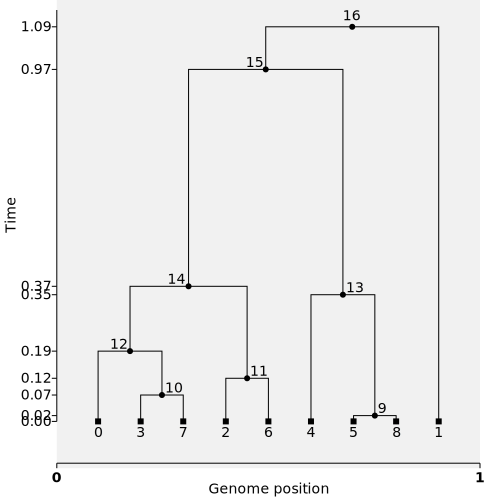

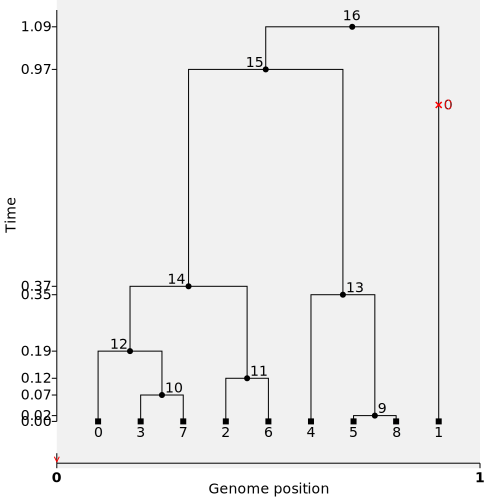

In [11]:
#SOL
display(SVG(ts_with_muts_1.draw_svg(size=(500, 500),y_axis=True)), SVG(ts_with_muts_2.draw_svg(size=(500, 500),y_axis=True)))

By default `sim_ancestry` and `sim_mutations` use different random seeds. This means that every ancestry and mutation simulation will be different. It is useful to be able to replicate the same simulation; setting the same random seed guarantees this. Try this by rerunning the code chunk above!

## 1.5 Using `msprime` to find the distribution of genealogies and coalescent times

We have so far only simulated single genealogies. We are usually interested in using coalescent simulations to understand the **distribution** of genealogies.

<div class="alert alert-block alert-warning">
    <b>Python recipe:</b> The <code>num_replicates</code> argument of <code>sim_ancestry()</code> provides a convenient and efficient way to iterate over a number of replicate simulations. Let's use this to examine the distribution of the time to the most recent common ancestor.

In [15]:
num_replicates = 1_000
tmrca_msprime = np.zeros(num_replicates)
replicates = msprime.sim_ancestry(9, ploidy=1, num_replicates=num_replicates, random_seed=42)
for replicate_index, ts in enumerate(replicates):
    tree = ts.first()
    tmrca_msprime[replicate_index] = tree.time(tree.root)

Note that the output of `sim_ancestry()` is a generator:

In [13]:
type(replicates)

generator

<div class="alert alert-block alert-warning">
    <b>Python recipe:</b> We will use <code>for</code> loops like the one above for populating numpy arrays with simulation results throughout the course, so it's worth understanding the syntax used: <code>np.zeros()</code> sets up an empty <code>numpy</code> array. It’s important to note that the replicate simulations are generated lazily here on demand — the set of simulations we have specified using <code>sim_ancestry</code> and assigned to the <code>replicates</code> variable is also a <code>generator</code>. This means that simulations are only specified but not actually run when we define <code>replicates</code>. 

Inside the <code>for</code> loop we use the built-in <code>enumerate()</code> function to easily get the index of each replicate in the list. Each replicate simulation is done sequentially as we go through the loop. We therefore only use the memory that we need to represent the results of one simulation.

<div class="alert alert-block alert-warning">
    <b>Note:</b> the type of  <code>sim_ancestry()</code> changes when we use the  <code>num_replicates </code> argument. If num_replicates is not specified or None, we return an instance of <code>tskit.TreeSequence</code>. If it is specified, we return an iterator over a set of <code>tskit.TreeSequence </code> instances.

<div class="alert alert-block alert-success">    
    <b>Exercise 12:</b>  What is the mean $T_{mrca}$? How does the distribution compare to the one we obtained using our own coalescence time simulator <code>coaltimes</code> at the top?

In [27]:
#SOL
print("The mean Tmrca is", tmrca_msprime.mean()*20000)
print("The mean Tmrca is", tmrca.mean())

The mean Tmrca is 35990.76569596264
The mean Tmrca is 34463.93973245694


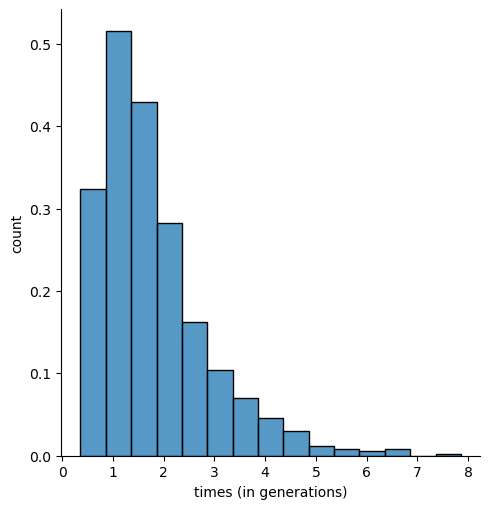

In [28]:
#SOL
sns.displot(x = tmrca_msprime, stat = "density", label = 'span of trees', binwidth = 0.5)
plt.xlabel("times (in generations)");
plt.ylabel("count")
plt.show()

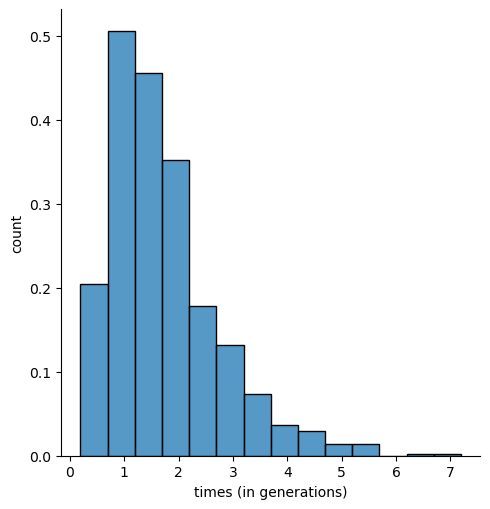

In [29]:
##SOL
sns.displot(x = tmrca/20_000, stat = "density", label = 'span of trees', binwidth = 0.5)
plt.xlabel("times (in generations)");
plt.ylabel("count")
plt.show()

## 1.6 Counting trees...

We have **still** only considered coalescence times and ignored topologies. How random are tree topologies under the standard neutral coalescent? The number of possible tree topologies grows very quickly with sample size and is **enormous** even for relatively small samples.

We can generate all trees using `tskit.all_trees(i, span=1)`

<div class="alert alert-block alert-warning">
    <b>Python recipe:</b> Use <a href="https://seaborn.pydata.org/generated/seaborn.lineplot.html"><code>sns.lineplot()</code></a> for plotting simple functions and datasets

For a samples of 7 lineages the number of unique tree topologies is 39208


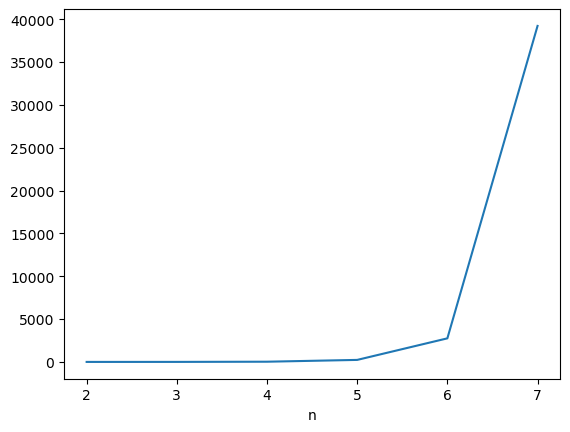

In [3]:
num_trees = [len(list(enumerate(tskit.all_trees(i, span=1)))) for i in range(2,8)]
print("For a samples of 7 lineages the number of unique tree topologies is", num_trees[-1])
n_samp = np.arange(2,8)
plt.xlabel('n')
sns.lineplot(x = n_samp, y =  num_trees)
plt.show()

<div class="alert alert-block alert-success">    
    <b>Exercise 13:</b>  Use the method <a href="https://tskit.dev/tskit/docs/stable/topological-analysis.html#sec-tree-ranks"><code>rank</code></a> to find the shape of each of the 1_000 simulated trees. Set up an empty numpy array and use a for loop over <code>enumrate(replicates)</code> to add the shape integer of each simulated tree to this array (analogous to the loop at the start of trhis section).

In [37]:
#SOL rank generates a tuple, the first element is an integer which uniquely records the unlabelled shape of a tree.
num_replicates = 1_000
rep_shapes = np.zeros(num_replicates)
replicates = msprime.sim_ancestry(9, ploidy=1, num_replicates=num_replicates, random_seed=42)
for replicate_index, ts in enumerate(replicates):
    tree = ts.first()
    rep_shapes[replicate_index] = tree.rank()[0]

<div class="alert alert-block alert-warning">
    <b>Python recipe:</b> <a href="https://realpython.com/python-counter/"><code>Counter</code></a> is extremely useful. The output is a python dictionary.

<div class="alert alert-block alert-success">    
    <b>Exercise 14:</b> Use a <code>Counter</code> to find out how many unique tree shapes you have simulated. How does this compare to the number possible bifurcating tree shapes, which for $n=9$ is 46 (Felsenstein, 2004)?

In [38]:
#SOL
count_dict = Counter(rep_shapes)
print("The number of unique tree shapes is", len(count_dict))

The number of unique tree shapes is 46


`Counter` returns a python dictionary. `most_common()` returns the key and value (in this case the count) of a `Counter`:

In [46]:
most_freq_rank, count = count_dict.most_common()[0]
print(most_freq_rank)
print(count)

753.0
91


<div class="alert alert-block alert-success">    
    <b>Exercise 15:</b> If we focus on the root partition and consider a sample of $n=9$ how likely are asymmetric trees, i.e. with a (8,1) compared to very symetric trees (5,4)? Check the frequency of all root partitions in the 1_000 replicates.

Use the function <code>get_root_bipartition</code> defined below!

In [47]:
def get_root_bipartition(tree):
    root_children = tree.children(tree.root)
    left_clade_n = len(sorted(tree.leaves(root_children[0])))
    right_clade_n = len(sorted(tree.leaves(root_children[1])))
    return sorted((left_clade_n, right_clade_n))[0]

In [48]:
get_root_bipartition(simple_tree)

8

In [49]:
#SOL
num_replicates = 1_000
rep_partitions = np.zeros(num_replicates)
replicates = msprime.sim_ancestry(9, ploidy=1, num_replicates=num_replicates, random_seed=42)
for replicate_index, ts in enumerate(replicates):
    tree = ts.first()
    rep_partitions[replicate_index] = get_root_bipartition(tree)

In [50]:
counts = Counter(rep_partitions)
count_array = np.zeros(4)
for index, root_partition in enumerate(counts):
    count_array[index] =  counts[root_partition]
    print("There are", counts[root_partition], "genealogies with a root partition", root_partition)

There are 229 genealogies with a root partition 3.0
There are 254 genealogies with a root partition 4.0
There are 247 genealogies with a root partition 1.0
There are 270 genealogies with a root partition 2.0


<div class="alert alert-block alert-warning">
    <b>Python recipe:</b> Statistical tests with <code>scipy</code>. We can check whether counts are significantly different from each other with a $\chi^2$ test:

In [128]:
#By hand good for the soul
chi_square = ((count_array - 250)**2)/250;
print(chi_square.sum())

3.4640000000000004


In [131]:
#SOL scipy
from scipy.stats import chisquare
chisquare(count_array)

Power_divergenceResult(statistic=3.4640000000000004, pvalue=0.3254613028395365)